# Bayesian Bandits

In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = (6.4, 3.2)

A few utility functions:

In [2]:
def plot_prior(trace, **options):
    return az.plot_posterior(trace, group='prior', **options);

def plot_posterior_predictive(trace, **options):
    return az.plot_posterior(trace, group='posterior_predictive', **options);

def run_samplers(model, *args, **options):
    with model:
        # Sample the prior predictive
        prior_pred = pm.sample_prior_predictive()

        # Sample from the posterior
        trace = pm.sample(*args, **options)

        # Sample from the posterior predictive
        posterior_pred = pm.sample_posterior_predictive(trace)

    trace.extend(prior_pred)
    trace.extend(posterior_pred)
    
    return trace

## A/B Testing

Let's get back to the first example from the previous notebook, estimating the conversion rate of an email campaign.

For purposes of simulation, let's assume that the actual long run conversion rate for version A is 10%.
We'll use a dictionary to keep track of this probability, `p`, the number of times we have tested this version, `n`, and the number of successful conversions, `k`.

In [3]:
A = dict(p=0.1, n=0, k=0)

When we run a campaign, we'll update this dictionary with the number of people we contact and the number of conversions, drawn from a binomial distribution with parameters `n` and `p`.

In [4]:
from scipy.stats import binom

def run_campaign(d, n=100):
    d['n'] += n
    d['k'] += binom.rvs(n=n, p=d['p'])

As an example, suppose we send version A to 100 people.

In [5]:
run_campaign(A, 100)
A

{'p': 0.1, 'n': 100, 'k': 12}

We can use the model from the previous notebook to estimate the conversion rate.

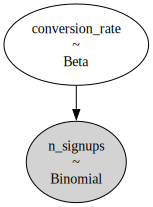

In [7]:
with pm.Model() as model:

    conversion_rate = pm.Beta("conversion_rate", 2, 5)

    pm.Binomial("n_signups", p=conversion_rate, n=A['n'], observed=A['k'])

model.to_graphviz()

In [8]:
with model:
    
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here's the posterior distribution.

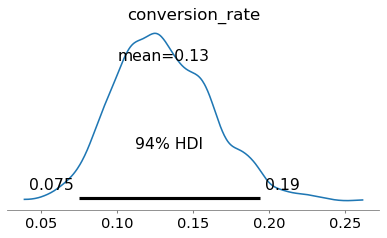

In [9]:
az.plot_posterior(trace);

Now suppose we introduce a new promotion that we think is more enticing, and for the sake of the example, we'll assume it is in fact more effective, so `p=0.15`.

In [10]:
B = dict(p=0.15, n=0, k=0)

But we don't know yet that B is more effective, so we'll do an uneven A/B test where we send the new email to 20 people in the next batch of 100.

In [11]:
run_campaign(A, 80)
A

{'p': 0.1, 'n': 180, 'k': 23}

In [12]:
run_campaign(B, 20)
B

{'p': 0.15, 'n': 20, 'k': 0}

Now let's update our beliefs.

## Loop Back to Here

Here's the previous model extended to estimate conversion rates for A and B.

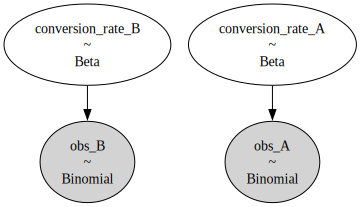

In [13]:
with pm.Model() as model_AB:
    
    # Priors for conversion rates of A and B
    conversion_rate_A = pm.Beta("conversion_rate_A", alpha=2, beta=5)
    conversion_rate_B = pm.Beta("conversion_rate_B", alpha=2, beta=5)
    
    # Likelihoods for observed data
    obs_A = pm.Binomial("obs_A", p=conversion_rate_A, n=A['n'], observed=A['k'])
    obs_B = pm.Binomial("obs_B", p=conversion_rate_B, n=B['n'], observed=B['k'])

model_AB.to_graphviz()

In [14]:
with model_AB:
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_A, conversion_rate_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here are the posterior distributions.

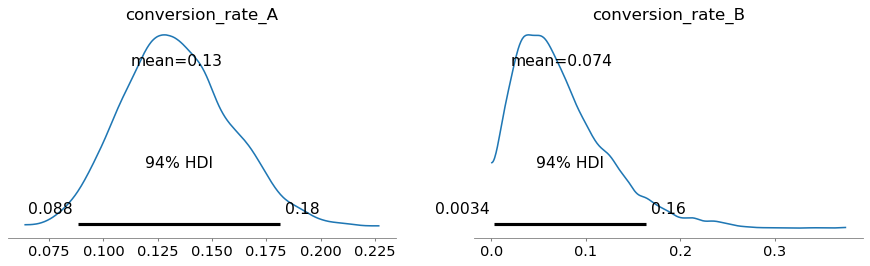

In [15]:
az.plot_posterior(trace);

Here's how we can plot them on the same axes.

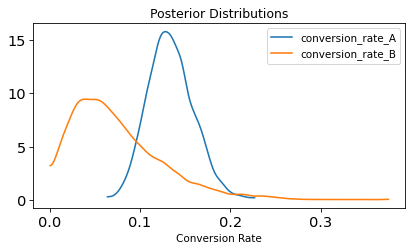

In [16]:
posterior = az.extract(trace)
samples_A = posterior["conversion_rate_A"].values
samples_B = posterior["conversion_rate_B"].values

az.plot_kde(samples_A, label="conversion_rate_A")
az.plot_kde(samples_B, label="conversion_rate_B", plot_kwargs={"color": "C1"})

plt.xlabel("Conversion Rate")
plt.title("Posterior Distributions")
plt.legend();

Based on these results, it looks like B is better, but the distributions overlap, so we might be tempted to run a hypothesis test.

But rather than merely distinguishing between "yes, there's a difference" or "no, there isn't", it is more useful to compute the **distribution** of possible differences. We want to know **how different** the conversion rates are, not just whether they are different.

In [17]:
diff = samples_B - samples_A

Here's what it looks like.

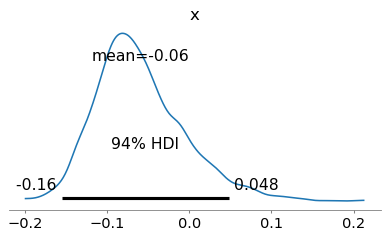

In [18]:
az.plot_posterior(diff, var_names=['x']);

On average, we think B is better (positive difference), but it's still possible that A is better (negative difference).

Here are the probabilities of superiority for A and B.

In [19]:
p_superior_A = (samples_A > samples_B).mean()
p_superior_B = (samples_B > samples_A).mean()

p_superior_A, p_superior_B

(0.86225, 0.13775)

At any point in time, these posterior distributions represent what we *believe* about A and B, but **how do we put those beliefs into action?**

## Thompson Sampling

One option is [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling), where we use A and B in proportion to their probability of superiority.
As long as we are unsure, we use them both about equally.
As we get confident that one is better, we use it more often.

For the next 100 emails, we'll use the probability of superiority to choose the proportions.

In [20]:
n = 100
n_A = (n * p_superior_A).round().astype(int)
n_B = n - n_A

n_A, n_B

(86, 14)

And we'll simulate the campaign.

In [21]:
run_campaign(A, n_A)
A

{'p': 0.1, 'n': 266, 'k': 26}

In [22]:
run_campaign(B, n_B)
B

{'p': 0.15, 'n': 34, 'k': 4}

Now go back and run the model again.
If you loop around a few times, you should see:

* The estimated conversion rates for A and B converge to their true values.

* The probability of superiority of B converges to 1.

* We gradually use A less and B more.

This strategy, also known as the [Bayesian bandit strategy](https://en.wikipedia.org/wiki/Multi-armed_bandit), is optimal in the sense that it maximizes expected utility given current beliefs.